## Changelog

2023-04-19, 11:33

*   Added Google Napoleon style documentation of functions.
*   Added and modified section headers and inline comments.

2023-04-17, 12:07

*   Extended range of values for tuning `C` parameter for LogisticRegression.
*   Fixed bug where saved confusion matrix figures would be empty.

2023-04-16, 16:28

*   Fixed bug with data leaking between training and test set due to not setting seed for numpy prior to undersampling in data preprocessing.

2023-04-15, 19:43

*   Added Gathering Results section.
*   Modified `test_models()` to handle single model input differently
*   Added `prepare_results()` to Gathering Results section for collecting all testing results, saving them to .csv and saving plots (only confusion matrices, currently).

2023-04-15, 15:02

*   Modified `train_models()` to integrate XGBoost.
*   Added model and model parameters for XGBoost.
*   Modified tuning parameter values for Random Forest and SVM.
*   Modified tuning parameter values for Logistic Regression to include both Ridge (L2) and LASSO (L1) penalties - with 'liblinear' solver as it is the only solver that works with both L1 and L2 penalties.
*   Added short set of instructions for notebook use under Setup section.

2023-04-12, 18:00

*   Added model saving and loading functionality (including model training results and metrics).
*   Removed non-SMOTE subsampling strategies from train_models().



## Google Colab Setup (COMMENT OUT IF NOT NEEDED)

In [ ]:
!cp -r drive/MyDrive/STAT841/Data/baf_data/ .
!cp -r drive/MyDrive/STAT841/Code/saved/ .
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [ ]:
#!cp -r saved/ drive/MyDrive/STAT841/Code/

# STAT 841: Final Project

## Setup

### Instructions

*   Make sure to set `loading_models` to correctly set to True or False, as desired.
*   If training models (not loading), make sure that relevant models and model parameters are included (uncommented) in the relevant code block under Training Pipeline section.
*   If training models, verify that correct CV scorer is selected, and that the `file_prefix` string and the `strategy` parameter for `train_models()` are appropriately set.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
## Set whether or not to load models or train from scratch
loading_models = True

## Load and view data

In [ ]:
data = pd.read_csv('baf_data/Base.csv')
n = len(data)
print(f'Number of entries: {n}.')
data.head()

Number of entries: 1000000.


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [ ]:
## Drop 'month' column as it is not a valid feature.
data = data.drop(columns=['month'])
data.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,24,0,500.0,0,INTERNET,3.888115,windows,0,1,0
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,15,0,1500.0,0,INTERNET,31.798819,windows,0,1,0
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,-1,0,200.0,0,INTERNET,4.728705,other,0,1,0
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,31,1,200.0,0,INTERNET,2.047904,linux,0,1,0
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,31,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0


In [ ]:
print('Number of missing values: ', data.isnull().sum().sum())

Number of missing values:  0


Class 0 (no fraud)
Count:  11029
Percentage of dataset:  1.1 %

Class 1 (fraud)
Count:  988971
Percentage of dataset:  98.9 %


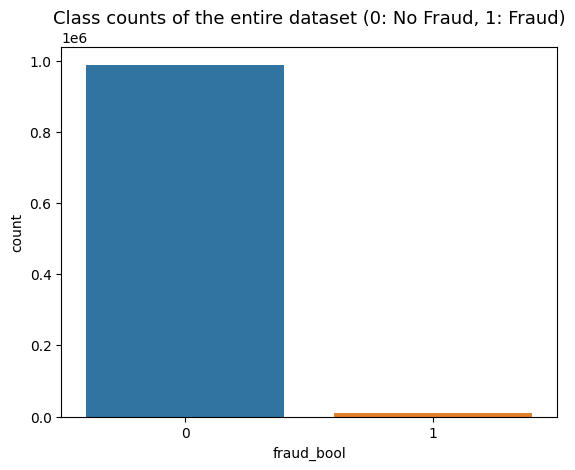

In [ ]:
sns.countplot(x='fraud_bool', data=data)
plt.title('Class counts of the entire dataset (0: No Fraud, 1: Fraud)', fontsize=13)

count_fraud, count_legit = data['fraud_bool'].value_counts()[1], data['fraud_bool'].value_counts()[0]
pctg_fraud, pctg_legit = round(count_fraud/n, 4), round(count_legit/n, 4)

print('Class 0 (no fraud)\nCount: ', count_fraud)
print('Percentage of dataset: ', round(pctg_fraud * 100,2), '%')

print('\nClass 1 (fraud)\nCount: ', count_legit)
print('Percentage of dataset: ', round(pctg_legit * 100,2), '%')

## Create a sample from the whole dataset

This dataset is huge and largely imbalanced. We have drawn a smaller sample without replacement for the classifiers to run on. We have assigned weights to each entry according to its label's rareness, such that "fraud" as the rarer class has a larger probability to be included. The resulted sample is more balanced.

Class 0 (no fraud)
Count:  11029
Percentage of sample:  1.1 %

Class 1 (fraud)
Count:  88971
Percentage of sample:  8.9 %


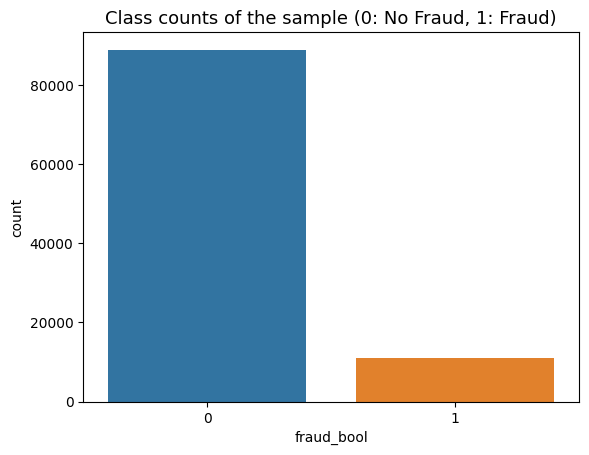

In [ ]:
# Set seed for reproducibility
np.random.seed(841)

# A vector of the probability of each sample being drawn
probabilities = [pctg_legit/count_fraud if label == 1 else pctg_fraud/count_legit for label in data["fraud_bool"]]
sample = data.loc[np.random.choice(data.index, size=100000, replace= False, p=probabilities)]

# plot the resulting sample's distribution
sns.countplot(x='fraud_bool', data=sample)
plt.title('Class counts of the sample (0: No Fraud, 1: Fraud)', fontsize=13)

count_fraud_sample = sample['fraud_bool'].value_counts()[1]
count_legit_sample = sample['fraud_bool'].value_counts()[0]
pctg_fraud_sample = round(count_fraud_sample/n, 4) 
pctg_legit_sample = round(count_legit_sample/n, 4)

print('Class 0 (no fraud)\nCount: ', count_fraud_sample)
print('Percentage of sample: ', round(pctg_fraud_sample * 100,2), '%')

print('\nClass 1 (fraud)\nCount: ', count_legit_sample)
print('Percentage of sample: ', round(pctg_legit_sample * 100,2), '%')

## Data preprocessing

In [ ]:
###### View all categorical columns
cat_cols = [col for col in sample.columns if sample[col].dtype == 'O']
cat_cols

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

In [ ]:
###### One-hot encode all categorical columns
def one_hot_data(orig_data, features_to_encode):
    res = orig_data
    for f in features_to_encode:
        dummies = pd.get_dummies(orig_data[[f]])
        res = pd.concat([res, dummies], axis=1)
        res = res.drop([f], axis=1)
    return res

sample_1hot = one_hot_data(sample, cat_cols)
sample_1hot.shape # dimension after one-hot transformation

(100000, 52)

In [ ]:
# ###### Normalize data (numerical columns)
# from sklearn.preprocessing import StandardScaler

# num_cols = [col for col in sample.columns.drop('fraud_bool') if sample[col].dtype != 'O'] # numerical columns

# std_scaler = StandardScaler()
# sample_1hot[num_cols] = std_scaler.fit_transform(sample_1hot[num_cols])

In [ ]:
###### Train-test split
from sklearn.model_selection import StratifiedShuffleSplit

k_fold = 5

sss = StratifiedShuffleSplit(n_splits= k_fold, test_size= 0.15, random_state=0)
X = sample_1hot[sample_1hot.columns.drop("fraud_bool")]
y = sample_1hot["fraud_bool"]

for train_index, test_index in sss.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
# ####### Set up 5-fold cross-validation

# k_fold = 5
# X = sample_1hot[sample_1hot.columns.drop("fraud_bool")].to_numpy()
# y = sample_1hot["fraud_bool"].to_numpy()

# # Use "StratifiedShuffleSplit" so the class ratios are preserved in both train and test dataset
# sss = StratifiedShuffleSplit(n_splits= k_fold, test_size= 0.15, random_state= 0)

## Training Pipeline

In [ ]:
import time

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.utils import class_weight

from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, matthews_corrcoef, make_scorer, classification_report


In [ ]:
def convert_duration(duration):
  """
  Helper function to convert a duration in seconds to hours, minutes, and seconds.

  Args:
    duration (int): The duration in seconds to be converted.

  Returns:
    Tuple[int, int, int]: A tuple containing the number of hours, minutes, and seconds
      represented by the input duration. Each value is an integer.
  """  
  hours, rem = divmod(duration, 3600)
  minutes, seconds = divmod(rem, 60)
  return int(hours), int(minutes), int(seconds)  

def train_models(models, model_params, X_train, y_train, scaler, scorer, strategy='None'):
  """
  Train machine learning models using grid search and cross-validation.

  Args:
    models (dict): A dictionary mapping model names to Scikit-Learn estimator objects.
    model_params (dict): A dictionary mapping model names to dictionaries of hyperparameter values
      to search over using grid search cross-validation.
    X_train (array-like of shape (n_samples, n_features)): The training input samples.
    y_train (array-like of shape (n_samples,)): The target values.
    scaler (Scikit-Learn scaler object): A scaler object used to preprocess the input data.
    scorer (Scikit-Learn scorer object): A scorer object used to evaluate model performance.
    strategy (str, optional): An oversampling strategy to use with imbalanced data. Defaults to 'None'.

  Returns:
    Tuple[dict, dict, dict, dict]: A tuple containing dictionaries of trained models, best model parameters,
      training times, and cross-validation scores for each model. Each dictionary maps model names to the
      corresponding values.
  """
  trained_models = {}
  trained_model_params = {}
  training_times = {}
  cv_scores = {}

  skfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

  for model_name in models:
    model_class = models[model_name].__class__
    print(model_class.__name__)
    print('\nCross-validation with strategy: {}, for {}'.format(strategy, model_class.__name__))

    tuning_params = model_params[model_name].copy()

    ## Setup pipeline based on imbalanced learning strategy
    if strategy == 'SMOTE':
      print('Oversampling with SMOTE')
      pipeline = Pipeline([('scaler',scaler), ('sampl',SMOTE(sampling_strategy='minority')), ('cf', model_class())]) 
    elif strategy == 'Cost':
      print('Cost-sensitive')
      if model_name == 'XGBoost':
        # XGBClassifier has scale_pos_weight parameter instead of class_weight.
        # For equivalent balanced weighting, we take weight as (Sum of No Fraud / Sum of Fraud)
        xgb_weight = np.count_nonzero(y_train == 0) / np.count_nonzero(y_train == 1)
        tuning_params['cf__scale_pos_weight'] = [xgb_weight]
        pipeline = Pipeline([('scaler',scaler), ('cf', model_class())])
      else:
        #tuning_params['cf__class_weight'] = ['balanced']
        pipeline = Pipeline([('scaler',scaler), ('cf', model_class(class_weight='balanced'))]) 
    elif strategy == 'None':
      print('No subsampling')
      pipeline = Pipeline([('scaler',scaler), ('cf', model_class())]) 
    else:
      print('Invalid strategy')
      return

    ## Grid Search CV
    grid_search_cv = GridSearchCV(pipeline, model_params[model_name], \
                                  n_jobs = 3, scoring=scorer, \
                                  cv = skfold, return_train_score=True, verbose=1)
    
    ## Start training
    start_time = time.time()

    grid_search_cv.fit(X_train, y_train)
    cv_score = cross_val_score(grid_search_cv, X_train, y_train, scoring=scorer, cv=skfold)

    train_time = time.time() - start_time
    hours, minutes, seconds = convert_duration(train_time)
    print('Training took {} hour(s) {} minute(s) {} second(s)\n'.format(int(hours), int(minutes), int(seconds)))

    ## Add model and results to output
    trained_models[model_name] = grid_search_cv.best_estimator_
    trained_model_params[model_name] = grid_search_cv.best_params_
    training_times[model_name] = train_time
    cv_scores[model_name] = cv_score

    print(model_class.__name__)
    print('')
    print("Parameters: {}".format(grid_search_cv.best_params_))
    print("Score: {}".format(grid_search_cv.best_score_))
    print('---' * 45)

  return trained_models, trained_model_params, training_times, cv_scores

## Train Model(s)

In [ ]:
###### Setup models, tuning parameters, scaler and scorer
xgb_weight = np.count_nonzero(y_train == 0) / np.count_nonzero(y_train == 1)

models = {
    # 'LogReg': LogisticRegression(),
    # 'SVC': SVC(),
    # 'RF': RandomForestClassifier(), # RandomForest does not have a straightforward way of determining what values of alpha to consider - do pre-pruning instead
    'XGBoost': XGBClassifier()
}

model_params = {
    # 'LogReg': {'cf__penalty': ['l1', 'l2'], 'cf__solver': ['liblinear'], 'cf__C': [(10 ** n) for n in range(-4,4)]},
    # 'SVC': {'cf__C': [(10 ** n) for n in range(-1,2)], 'cf__kernel': ['rbf', 'poly', 'linear']},
    # 'RF': {'cf__n_estimators': [50, 75, 100], 
    #        'cf__max_depth': [None if n < 0 else n for n in range(-5,20,6)]}, 
    'XGBoost': {'cf__tree_method': ["gpu_hist"], # With GPU
                'cf__scale_pos_weight': [xgb_weight], # for cost-sensitive
                'cf__eta': [0.01, 0.1, 0.2],  
                'cf__max_depth': list(range(3,10,3)), 
                'cf__min_child_weight': list(range(1,6,2)), 
                'cf__gamma': [n/10.0 for n in range(0,3)]}
}

std_scaler = StandardScaler()
mcc_scorer = make_scorer(matthews_corrcoef)
#f1_scorer = make_scorer(f1_score)

In [ ]:
###### Train and save model, or load pre-trained model
import pickle

file_prefix = 'cost_xgboost_'

if loading_models:
  trained_models = pickle.load(open('saved/{}trained_models.sav'.format(file_prefix), 'rb'))
  params = pickle.load(open('saved/{}params.sav'.format(file_prefix), 'rb'))
  training_times = pickle.load(open('saved/{}training_times.sav'.format(file_prefix), 'rb'))
  scores = pickle.load(open('saved/{}scores.sav'.format(file_prefix), 'rb'))
else:
  trained_models, params, training_times, scores = train_models(models, 
                                                                model_params, 
                                                                X_train, 
                                                                y_train, 
                                                                scaler=std_scaler, 
                                                                scorer=mcc_scorer, 
                                                                strategy='Cost')
  
  pickle.dump(trained_models, open('saved/{}trained_models.sav'.format(file_prefix), 'wb'))
  pickle.dump(params, open('saved/{}params.sav'.format(file_prefix), 'wb'))
  pickle.dump(training_times, open('saved/{}training_times.sav'.format(file_prefix), 'wb'))
  pickle.dump(scores, open('saved/{}scores.sav'.format(file_prefix), 'wb'))

XGBClassifier

Cross-validation with strategy: Cost, for XGBClassifier
Cost-sensitive
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training took 0 hour(s) 35 minute(s) 7 second(s)

XGBClassifier

Parameters: {'cf__eta': 0.1, 'cf__gamma': 0.2, 'cf__max_depth': 9, 'cf__min_child_weight': 3, 'cf__scale_pos_weight': 8.066666666666666, 'cf__tree_method': 'gpu_hist'}
Score: 0.4771211112094161
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# For overnight running
#!cp -r saved/ drive/MyDrive/STAT841/Code/

## Model Testing

In [ ]:
import os

def print_results(metrics, index):
  """
  Helper function to print the evaluation metrics for a binary classification model.

  Args:
    metrics (dict): A dictionary containing evaluation metrics for one or more binary classification models. The keys in the dictionary 
      should be 'accuracy', 'precision', 'recall', 'f1_score', 'roc_score', and 'mcc_score', and the values should
      be lists of metric values for each model.
    index (int): An integer indicating the index of the model for which to print the evaluation metrics.

  Returns:
    None
  """
  print("accuracy: {}".format(metrics['accuracy'][index]))
  print("precision: {}".format(metrics['precision'][index]))
  print("recall: {}".format(metrics['recall'][index]))
  print("f1: {}".format(metrics['f1_score'][index]))
  print('ROC AUC: {}'.format(metrics['roc_score'][index]))
  print('MCC: {}'.format(metrics['mcc_score'][index]))


def test_models(trained_models, X_test, y_test, strategy=None, save_folder_path=None):
  """
  Test trained models on test data and calculate evaluation metrics.

  Args:
    trained_models (dict): A dictionary of trained models.
    X_test (array-like): Test features.
    y_test (array-like): Test labels.
    strategy (str, optional): The strategy used to train the models. Defaults to None.
    save_folder_path (str, optional): Path to the folder where the confusion matrices will be saved. Defaults to None.

  Returns:
    dict: A dictionary with the evaluation metrics of each model.
  """
  labels = ['No Fraud', 'Fraud']
  all_results = {'strategy': [],
                 'model': [], 
                 'accuracy': [], 
                 'precision': [], 
                 'recall': [],
                 'f1_score': [],
                 'mcc_score': [],
                 'roc_score': [],
                 }

  # Prepare figure for confusion matrices
  fig, ax = plt.subplots(len(trained_models), 1, figsize=(4,len(trained_models)*3), squeeze=False) 
  fig.tight_layout(pad=5.0)
  index = 0

  for model_name, model in trained_models.items():

    model_class = model.named_steps['cf'].__class__.__name__
    print('Test results for model: ', model_class)
    print('')

    model_prediction = model.predict(X_test)

    print(classification_report(y_test, model_prediction, target_names=labels))

    # If specific strategy used, include in results
    if strategy:
      all_results['strategy'].append(strategy)
    else:
      all_results['strategy'].append('NA')

    # Collect results    
    all_results['model'].append(model_class)
    all_results['accuracy'].append(model.score(X_test, y_test))
    all_results['precision'].append(precision_score(y_test, model_prediction))
    all_results['recall'].append(recall_score(y_test, model_prediction))
    all_results['f1_score'].append(f1_score(y_test, model_prediction))
    all_results['mcc_score'].append(matthews_corrcoef(y_test, model_prediction))
    all_results['roc_score'].append(roc_auc_score(y_test, model_prediction))

    print_results(all_results, index)

    if len(trained_models) > 1:
      print('---' * 45)

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, model_prediction)
    sns.heatmap(conf_mat, ax=ax[index][0], annot=True, cmap=plt.cm.Reds, fmt='d')
    if strategy:
      ax[index, 0].set_title("{} {}".format(strategy, model_class), fontsize=11)
    else:
      ax[index, 0].set_title("{}".format(model_class), fontsize=11)
    ax[index, 0].set_xticklabels(labels, fontsize=8, rotation=0)
    ax[index, 0].set_yticklabels(labels, fontsize=8, rotation=360)
    ax[index, 0].set_ylabel('Actual Class')
    ax[index, 0].set_xlabel('Predicted Class')

    index += 1

  print('')
  plt.show()

  # Save confusion matrix if only one model provided
  if save_folder_path:
    filename = ''
    if strategy:
      filename = strategy.lower() + '_'
    
    if len(trained_models) == 1:
      filename = filename + list(trained_models.keys())[0].lower() + '_'

    filename = filename + 'conf_matrix.png'

    fig.savefig(os.path.join(save_folder_path, filename), bbox_inches='tight')

  return all_results



Test results for model:  XGBClassifier

              precision    recall  f1-score   support

    No Fraud       0.96      0.89      0.92     13346
       Fraud       0.44      0.70      0.54      1654

    accuracy                           0.87     15000
   macro avg       0.70      0.79      0.73     15000
weighted avg       0.90      0.87      0.88     15000

accuracy: 0.8676666666666667
precision: 0.4372392870686386
recall: 0.6970979443772672
f1: 0.5374038685621068
ROC AUC: 0.7929517895121763
MCC: 0.482117020868202



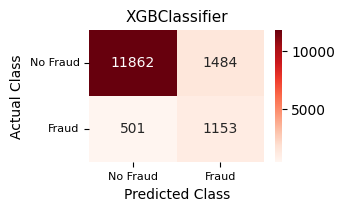

In [ ]:
results = test_models(trained_models, X_test, y_test)

In [ ]:
results

{'strategy': ['NA'],
 'model': ['XGBClassifier'],
 'accuracy': [0.8676666666666667],
 'precision': [0.4372392870686386],
 'recall': [0.6970979443772672],
 'f1_score': [0.5374038685621068],
 'mcc_score': [0.482117020868202],
 'roc_score': [0.7929517895121763]}

In [ ]:
#params

In [ ]:
#trained_models['RF'].named_steps['cf'].get_params()

## Gathering Results

In [ ]:
## Assumes one model per pickled file
def prepare_results(save_folder_path, result_folder_path, strategies, model_names, X_test, y_test):
  """
  Prepare the test results for each model trained with different strategies, save them to a CSV file 
    and return the corresponding Pandas DataFrame. 

  Args:
    save_folder_path (str): Path to the folder where trained models, parameters, scores, and training times are saved.
    result_folder_path (str): Path to the folder where the test results will be saved.
    strategies (list): List of strategies used for training the models.
    model_names (list): List of names of models to be tested.
    X_test (array-like): Test set features.
    y_test (array-like): Test set labels.

  Returns:
    all_results (DataFrame): DataFrame containing test results of each model trained with different strategies.

  Raises:
    FileNotFoundError: If the save_folder_path does not exist.            
  """
  all_results = list()

  for strategy in strategies:
    print("\nProcessing models trained with \'{}\' strategy.".format(strategy))

    for model_name in model_names:
      print("\n{}:\n".format(model_name))
      model = pickle.load(open('{}/{}_{}_trained_models.sav'.format(save_folder_path, strategy.lower(), model_name.lower()), 'rb'))
      params = pickle.load(open('{}/{}_{}_params.sav'.format(save_folder_path, strategy.lower(), model_name.lower()), 'rb'))
      training_times = pickle.load(open('{}/{}_{}_training_times.sav'.format(save_folder_path, strategy.lower(), model_name.lower()), 'rb'))
      scores = pickle.load(open('{}/{}_{}_scores.sav'.format(save_folder_path, strategy.lower(), model_name.lower()), 'rb'))
      
      ## Get test results
      model_results = test_models(model, X_test, y_test, strategy, result_folder_path)

      for key, val in model_results.items():
        # Extract values from list
        model_results[key] = val[0]

      ## Add training_times, params and scores
      model_results['training_time'] = training_times[model_name]
      model_results['model_params'] = params[model_name]
      model_results['cv_scores'] = scores[model_name]
      print(scores[model_name])

      all_results.append(model_results)

    print('\n' + '---' * 45)
  
  all_results = pd.DataFrame.from_records(all_results) 
  all_results.to_csv(os.path.join(result_folder_path, 'all_results.csv')) 

  return all_results


Processing models trained with 'Base' strategy.

LogReg:

Test results for model:  LogisticRegression

              precision    recall  f1-score   support

    No Fraud       0.92      0.98      0.95     13346
       Fraud       0.65      0.32      0.43      1654

    accuracy                           0.91     15000
   macro avg       0.79      0.65      0.69     15000
weighted avg       0.89      0.91      0.89     15000

accuracy: 0.9062666666666667
precision: 0.6519607843137255
recall: 0.3216444981862152
f1: 0.43076923076923074
ROC AUC: 0.650182356990605
MCC: 0.4148086305658591



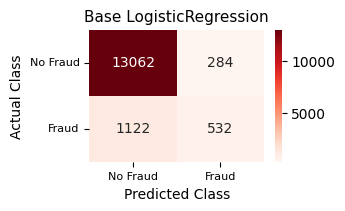

[0.41832253 0.42707889 0.44205627 0.42984699 0.42915262]

RF:

Test results for model:  RandomForestClassifier

              precision    recall  f1-score   support

    No Fraud       0.92      0.99      0.95     13346
       Fraud       0.72      0.27      0.39      1654

    accuracy                           0.91     15000
   macro avg       0.82      0.63      0.67     15000
weighted avg       0.89      0.91      0.89     15000

accuracy: 0.9078
precision: 0.7203252032520325
recall: 0.2678355501813785
f1: 0.39048038783605116
ROC AUC: 0.6274738967750891
MCC: 0.40271896270047947



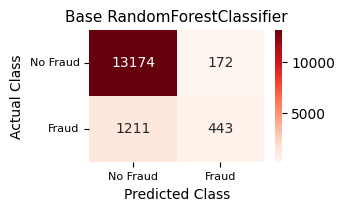

[0.39232531 0.40321367 0.41429885 0.40968577 0.38207211]

XGBoost:

Test results for model:  XGBClassifier

              precision    recall  f1-score   support

    No Fraud       0.93      0.98      0.95     13346
       Fraud       0.70      0.37      0.49      1654

    accuracy                           0.91     15000
   macro avg       0.81      0.68      0.72     15000
weighted avg       0.90      0.91      0.90     15000

accuracy: 0.9133333333333333
precision: 0.7006802721088435
recall: 0.373639661426844
f1: 0.48738170347003157
ROC AUC: 0.676929226787152
MCC: 0.47114220130825574



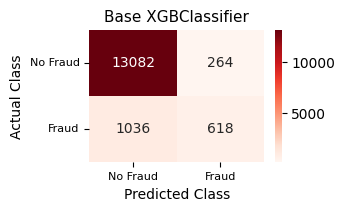

[0.47364072 0.46298461 0.4848551  0.47490325 0.46448186]

---------------------------------------------------------------------------------------------------------------------------------------

Processing models trained with 'SMOTE' strategy.

LogReg:

Test results for model:  LogisticRegression

              precision    recall  f1-score   support

    No Fraud       0.97      0.82      0.89     13346
       Fraud       0.34      0.77      0.48      1654

    accuracy                           0.81     15000
   macro avg       0.65      0.80      0.68     15000
weighted avg       0.90      0.81      0.84     15000

accuracy: 0.8116666666666666
precision: 0.3430715625837577
recall: 0.7738814993954051
f1: 0.47539461467038074
ROC AUC: 0.7951154837004
MCC: 0.42767118561133083



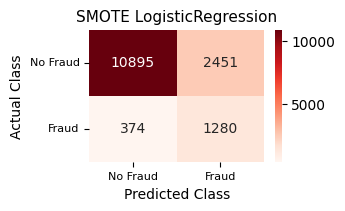

[0.42588286 0.43416801 0.4204781  0.42750929 0.42741532]

RF:

Test results for model:  RandomForestClassifier

              precision    recall  f1-score   support

    No Fraud       0.95      0.91      0.93     13346
       Fraud       0.46      0.60      0.52      1654

    accuracy                           0.88     15000
   macro avg       0.71      0.76      0.73     15000
weighted avg       0.90      0.88      0.89     15000

accuracy: 0.8797333333333334
precision: 0.4649859943977591
recall: 0.6021765417170496
f1: 0.5247629083245521
ROC AUC: 0.758154058360398
MCC: 0.4622275440256973



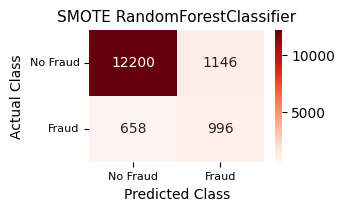

[0.47215543 0.45937085 0.45842488 0.44852038 0.46362896]

XGBoost:

Test results for model:  XGBClassifier

              precision    recall  f1-score   support

    No Fraud       0.94      0.96      0.95     13346
       Fraud       0.58      0.49      0.53      1654

    accuracy                           0.91     15000
   macro avg       0.76      0.72      0.74     15000
weighted avg       0.90      0.91      0.90     15000

accuracy: 0.9054666666666666
precision: 0.5847701149425287
recall: 0.4921402660217654
f1: 0.5344714379514117
ROC AUC: 0.7244157047177613
MCC: 0.4845178555302986



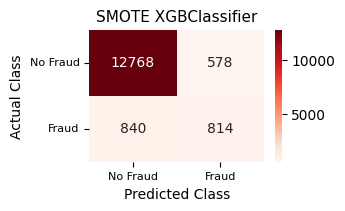

[0.48480965 0.50460123 0.47827477 0.48149215 0.49709507]

---------------------------------------------------------------------------------------------------------------------------------------

Processing models trained with 'Cost' strategy.

LogReg:

Test results for model:  LogisticRegression

              precision    recall  f1-score   support

    No Fraud       0.97      0.81      0.88     13346
       Fraud       0.33      0.79      0.47      1654

    accuracy                           0.80     15000
   macro avg       0.65      0.80      0.68     15000
weighted avg       0.90      0.80      0.83     15000

accuracy: 0.8037333333333333
precision: 0.3348694316436252
recall: 0.7908101571946796
f1: 0.4705035971223022
ROC AUC: 0.7980725445047278
MCC: 0.42548581230443133



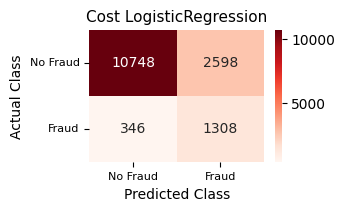

[0.42165791 0.42112043 0.42433957 0.42832447 0.41835894]

RF:

Test results for model:  RandomForestClassifier

              precision    recall  f1-score   support

    No Fraud       0.95      0.91      0.93     13346
       Fraud       0.46      0.62      0.52      1654

    accuracy                           0.88     15000
   macro avg       0.70      0.76      0.73     15000
weighted avg       0.90      0.88      0.88     15000

accuracy: 0.8768666666666667
precision: 0.45674585387718514
recall: 0.6160822249093107
f1: 0.5245817245817246
ROC AUC: 0.762634248974961
MCC: 0.4623772309497245



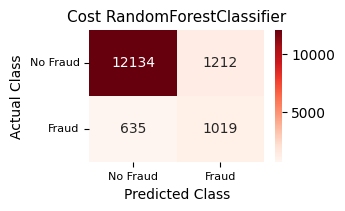

[0.45641208 0.47465903 0.46296407 0.45225948 0.46541343]

XGBoost:

Test results for model:  XGBClassifier

              precision    recall  f1-score   support

    No Fraud       0.96      0.89      0.92     13346
       Fraud       0.44      0.70      0.54      1654

    accuracy                           0.87     15000
   macro avg       0.70      0.79      0.73     15000
weighted avg       0.90      0.87      0.88     15000

accuracy: 0.8676666666666667
precision: 0.4372392870686386
recall: 0.6970979443772672
f1: 0.5374038685621068
ROC AUC: 0.7929517895121763
MCC: 0.482117020868202



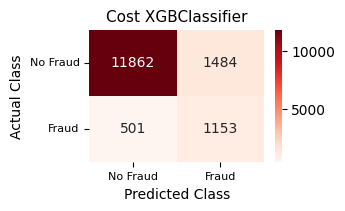

[0.4720808  0.47407429 0.47226726 0.47520983 0.47609236]

---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
##### Get all results

save_folder_rel_path = 'saved'
results_folder_rel_path = 'results'
strategies = ['Base', 'SMOTE', 'Cost']
model_names = ['LogReg', 'RF', 'XGBoost']

results = prepare_results(save_folder_rel_path, 
                          results_folder_rel_path, 
                          strategies, 
                          model_names, 
                          X_test, 
                          y_test)

In [ ]:
results

,strategy,model,accuracy,precision,recall,f1_score,mcc_score,roc_score,training_time,model_params,cv_scores
0,Base,LogisticRegression,0.906267,0.651961,0.321644,0.430769,0.414809,0.650182,1094.008490,"{'cf__C': 10, 'cf__penalty': 'l1', 'cf__solver...","[0.418322533093146, 0.42707889027584234, 0.442..."
1,Base,RandomForestClassifier,0.907800,0.720325,0.267836,0.390480,0.402719,0.627474,3600.330006,"{'cf__max_depth': None, 'cf__n_estimators': 75}","[0.3923253113687627, 0.4032136678953761, 0.414..."
2,Base,XGBClassifier,0.913333,0.700680,0.373640,0.487382,0.471142,0.676929,1984.737359,"{'cf__eta': 0.2, 'cf__gamma': 0.0, 'cf__max_de...","[0.4736407164849909, 0.46298461049479595, 0.48..."
3,SMOTE,LogisticRegression,0.811667,0.343072,0.773881,0.475395,0.427671,0.795115,974.110741,"{'cf__C': 0.1, 'cf__penalty': 'l1', 'cf__solve...","[0.4258828626777957, 0.4341680062063177, 0.420..."
4,SMOTE,RandomForestClassifier,0.879733,0.464986,0.602177,0.524763,0.462228,0.758154,5434.984471,"{'cf__max_depth': 13, 'cf__n_estimators': 75}","[0.47215542518609255, 0.4593708528088051, 0.45..."
5,SMOTE,XGBClassifier,0.905467,0.584770,0.492140,0.534471,0.484518,0.724416,3706.837207,"{'cf__eta': 0.2, 'cf__gamma': 0.2, 'cf__max_de...","[0.4848096511338287, 0.5046012328602169, 0.478..."
6,Cost,LogisticRegression,0.803733,0.334869,0.790810,0.470504,0.425486,0.798073,1625.598365,"{'cf__C': 1, 'cf__penalty': 'l1', 'cf__solver'...","[0.421657909560936, 0.42112042800147176, 0.424..."
7,Cost,RandomForestClassifier,0.876867,0.456746,0.616082,0.524582,0.462377,0.762634,2654.962461,"{'cf__max_depth': 13, 'cf__n_estimators': 100}","[0.4564120813703178, 0.4746590314105767, 0.462..."
8,Cost,XGBClassifier,0.867667,0.437239,0.697098,0.537404,0.482117,0.792952,2107.981018,"{'cf__eta': 0.1, 'cf__gamma': 0.2, 'cf__max_de...","[0.47208079868353847, 0.4740742874748555, 0.47..."


In [ ]:
# Saving to drive
#!cp -r results/ drive/MyDrive/STAT841/Code/